In [1]:
## Fast Import
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import pathlib
import time
import math, random
import pprint
import collections
import numbers, string

import yaml
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import albumentations as A

np.set_printoptions(precision=3)
curr_path = pathlib.Path(os.getcwd()).absolute()

cards = !echo $SGE_HGR_gpu_card
device = torch.device(f"cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Visualize Batches

In [2]:
from configs import get_config
cfg = get_config('./experiments/ftbcv/configs/ftbcv_train.yaml', merge_default=False)
cfg.experiment.distributed = False
cfg.experiment.rank = 0

cfg.train.batch_size = 20
cfg.train.num_workers = 0

from experiments.ftbcv.data_setup import get_data_components
data_d = get_data_components(cfg)
train_loader = data_d['train_loader']

 > Loading config (./experiments/ftbcv/configs/ftbcv_train.yaml).. done.
    Took 29.44s for sample creation.
    Took 31.10s for sample creation.
    Took 34.87s for sample creation.
    Took 36.44s for sample creation.
    Took 37.32s for sample creation.
    Took 40.03s for sample creation.
    Took 40.88s for sample creation.
    Took 42.92s for sample creation.
    Took 43.10s for sample creation.
    Took 43.43s for sample creation.
    Took 44.06s for sample creation.
    Took 44.31s for sample creation.
    Took 44.80s for sample creation.
    Took 44.82s for sample creation.
    Took 45.19s for sample creation.
    Took 46.97s for sample creation.
    Took 47.28s for sample creation.
    Took 50.11s for sample creation.
    Took 50.15s for sample creation.
    Took 50.22s for sample creation.
    Took 57.86s for sample creation.
    Took 58.50s for sample creation.
    Took 59.18s for sample creation.
    Took 64.44s for sample creation.
    Took 34.99s for sample creation.
  

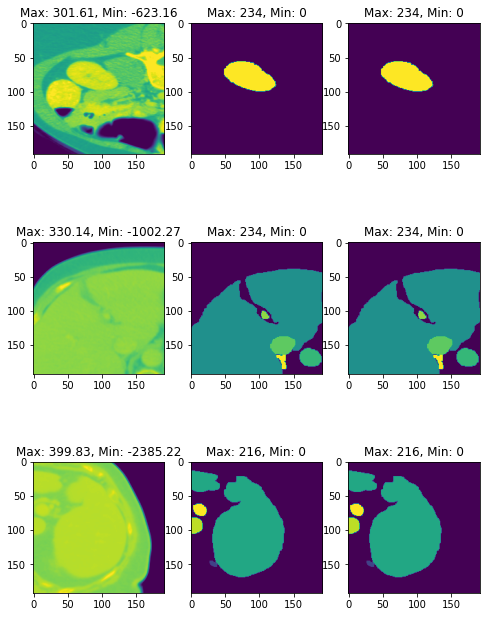

OrderedDict([('ZNormalize', {'mean': 82.92, 'std': 136.97}),
             ('ScaledForegroundCropper3d',
              {'foreground_ratio': 0.3288772017867477,
               'foreground_vol': 581939,
               'init_crop_lower': (35, 146, 52),
               'init_crop_shape': (48, 201, 173),
               'init_crop_upper': (83, 347, 225),
               'input_shape': (100, 512, 512),
               'interpolation': 'nearest',
               'output_shape': (48, 192, 192)}),
             ('Flip3d',
              {'flipped_flags': [False, True, True],
               'input_shape': (48, 192, 192),
               'output_shape': (48, 192, 192)}),
             ('GaussianNoise',
              {'input_shape': (48, 192, 192),
               'mean': 0.0,
               'output_shape': (48, 192, 192),
               'variance': 0.03143236041069031}),
             ('GaussianBlur',
              {'input_shape': (48, 192, 192),
               'output_shape': (48, 192, 192),
               

SystemExit: 1

In [6]:
## Visualize patches
from data.transforms import z_normalize, flip


for it, batch in enumerate(train_loader):
    samples = batch['samples']
    records = batch['records']
            
    X = batch['images'].float()
    Y_id = batch['masks'].long()
    Y_oh = batch['masks_1h']
    
    fig = plt.figure(figsize=(8, X.shape[0] * 4))
    N_rows, N_cols = X.shape[0], 3
    for i in range(X.shape[0]):
        
        tens = X[i][0]  # DxHxW
        mask = Y_id[i][0] * 18  # x18 for easy viewing
        mask_oh = Y_oh[i].argmax(0) * 18
        hist = records[i]
        sample = samples[i]
        
        # pprint.pprint(hist)
        
        un_tens = z_normalize.ZNormalize().invert(tens, hist['ZNormalize'])
        
        
        ax = fig.add_subplot(N_rows, N_cols, i * N_cols + 1)
        ax.set_title(f'Max: {un_tens.max().item():.2f}, Min: {un_tens.min().item():.2f}')
        ax.imshow(un_tens[tens.shape[0] // 2].cpu().numpy().astype(np.int16))
        ax = fig.add_subplot(N_rows, N_cols, i * N_cols + 2)
        ax.set_title(f'Max: {mask.max().item()}, Min: {mask.min().item()}')
        ax.imshow(mask[tens.shape[0] // 2].cpu().numpy().astype(np.int16))
        ax = fig.add_subplot(N_rows, N_cols, i * N_cols + 3)
        ax.set_title(f'Max: {mask_oh.max().item()}, Min: {mask_oh.min().item()}')
        ax.imshow(mask_oh[tens.shape[0] // 2].cpu().numpy().astype(np.int16))
        
        # Save Crop
        if hist['ScaledForegroundCropper3d']['foreground_ratio'] > 0.3:
            mask_arr = Y_id[i][0].cpu().numpy().astype(np.uint8)
            sitk_mask = sitk.GetImageFromArray(mask_arr)
            sitk_mask.SetOrigin(sample.mask.origin)
            sitk_mask.SetDirection(sample.mask.direction)
            sitk_mask.SetSpacing(sample.mask.spacing)
            sitk.WriteImage(sitk_mask, 'DB_crop_mask.nii.gz')

            crop_arr = un_tens.cpu().numpy().astype(np.int16)
            sitk_crop = sitk.GetImageFromArray(crop_arr)
            sitk_crop.SetOrigin(sample.image.origin)
            sitk_crop.SetDirection(sample.image.direction)
            sitk_crop.SetSpacing(sample.image.spacing)
            sitk.WriteImage(sitk_crop, 'DB_crop_image.nii.gz')
            
            break
        
        
#         ax = fig.add_subplot(2, 4, 3)
#         ax.set_title(f'Max: {un_tens2.max().item()}, Min: {un_tens2.min().item()}')
#         ax.imshow(un_tens2[tens2.shape[0] // 2].cpu().numpy().astype(np.int16))
        
#         un_tens1 = flip.Flip3d().invert(un_tens1, hist1['Flip3d'])
#         un_tens2 = flip.Flip3d().invert(un_tens2, hist2['Flip3d'])
        
#         ax = fig.add_subplot(2, 4, 3)
#         ax.set_title(f'Max: {un_tens1.max().item()}, Min: {un_tens1.min().item()}')
#         ax.imshow(un_tens1[tens1.shape[0] // 2].cpu().numpy().astype(np.int16))
#         ax = fig.add_subplot(2, 4, 4)
#         ax.set_title(f'Max: {un_tens2.max().item()}, Min: {un_tens2.min().item()}')
#         ax.imshow(un_tens2[tens2.shape[0] // 2].cpu().numpy().astype(np.int16))
    plt.show()
        
    pprint.pprint(hist)
    
    import sys; sys.exit(1)
    

# PGL Model + Crit + Optim + Scheduler Setup

In [8]:
from experiments.pgl.pgl_unet3d import UNet3D
from lib.nets.ema import create_ema_model, update_ema_model

model = UNet3D(n_input=1, n_class=1, act='relu')
ema_model = create_ema_model(UNet3D(n_input=1, n_class=1, act='relu'))
model, ema_model = model.to(device), ema_model.to(device)
if True:
    print(f'  * {-1} GPUs, using nn.DataParallel.')
    model = nn.DataParallel(model)
    ema_model = nn.DataParallel(ema_model)

💠 UNet3D-PGL model initiated with n_classes=1, 
   n_input=1, activation=relu, 
   params=19,073,665, trainable_params=19,073,665.
💠 UNet3D-PGL model initiated with n_classes=1, 
   n_input=1, activation=relu, 
   params=19,073,665, trainable_params=19,073,665.
  * -1 GPUs, using nn.DataParallel.


In [30]:
from lib.assess.losses3d import BYOL3d

criterion = BYOL3d()

# Test criterion 
pred = torch.randn((200, 1, 96, 96, 16))
targ = torch.randn((200, 1, 96, 96, 16))

# BYOL 2 - 2 * .. loss
def byol1(pred, targ):
    pred = pred.view(pred.shape[0], -1)
    targ = targ.view(targ.shape[0], -1)
    pred_norm = F.normalize(pred, dim=-1, p=2)
    targ_norm = F.normalize(targ, dim=-1, p=2)
    loss = torch.sum(2 - 2 * (pred_norm * targ_norm).sum(dim=-1)) / pred.shape[0]
    print(loss)
    return loss

def byol2(pred, targ):
    pred = pred.view(pred.shape[0], -1)
    targ = targ.view(targ.shape[0], -1)
    pred_norm = F.normalize(pred, dim=-1, p=2)
    targ_norm = F.normalize(targ, dim=-1, p=2)
    loss = ((pred_norm - targ_norm) ** 2).sum() / pred.shape[0]
    print(loss, '-')
    return loss

times1 = np.zeros(10)
times2 = np.zeros(10)
for i in range(10):
    start = time.time()
    byol1(pred, targ)
    times1[i] = time.time() - start
    
    start = time.time()
    byol2(pred, targ)
    times2[i] = time.time() - start
print(f'1: {times1.mean():.3f}, 2: {times2.mean():.3f}')


💠 Criterion: BYOL3d initiated.
1: 0.089, 2: 0.116


# PGL Data Setup

In [4]:
from experiments.pgl import data_setup

data_setup.get_data_components(None)
